In [1]:
library(tidyverse)
library(ggplot2)
library(Seurat)
library(patchwork)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Attaching SeuratObject

Attaching sp



In [2]:
obj = qs::qread('_targets/objects/obj_MOL')
obj

An object of class Seurat 
49768 features across 4023 samples within 3 assays 
Active assay: SCT (17447 features, 3000 variable features)
 2 other assays present: RNA, integrated
 2 dimensional reductions calculated: pca, umap

In [3]:
exp_neuron = qs::qread('../00_preprocessing/_targets/objects/exp_labelled_other')
exp_neuron

An object of class Seurat 
56583 features across 37179 samples within 3 assays 
Active assay: SCT (24262 features, 3000 variable features)
 2 other assays present: RNA, integrated
 2 dimensional reductions calculated: pca, umap

In [4]:
nhgc = qs::qread('_targets/objects/nhgc_MOL___all.obob5v5__v__all.obobBL6')
nhgc %>% head

rowname              restored_grouping fgf1_grouping
1 CTCCTCCTCAAGTAAG_3_2 pos_away          pos          
2 TTCCTTCTCGACGATT_1_3 pos_away          pos          
3 CGAGGCTAGTGTACCT_4_3 pos_away          pos          
4 CTCAATTCAAGGGCAT_4_1 pos_FGF1          pos          
5 CATCCCATCCGTGTGG_4_1 pos_FGF1          pos          
6 TGGAGGATCTCTTAAC_4_2 pos_FGF1          pos

In [5]:
make_kde2d = function(nhgc_coords){
    range_factor = 0.25
    x = nhgc_coords$UMAP_1
    y = nhgc_coords$UMAP_2
    x_min = min(x)
    x_max = max(x)
    x_range = x_max - x_min
    x_min = x_min - (range_factor * x_range)
    x_max = x_max + (range_factor * x_range)
    y_min = min(y)
    y_max = max(y)
    y_range = y_max - y_min
    y_min = y_min - (range_factor * y_range)
    y_max = y_max + (range_factor * y_range)
    kde = MASS::kde2d(x, y, n=100, lims = c(x_min, x_max, y_min, y_max))
    kde$labels = nhgc_coords$labels
    kde    
}

In [6]:
enframe_kde = function(kde){
    kde_df = data.frame(expand.grid(x=kde$x, y=kde$y, 
                                    labels=kde$labels), 
                                    z=as.vector(kde$z)) %>% distinct
    kde_df
}

In [7]:
filter_obj_to_nhgc = function(nhgc, obj){
    subset_cells = nhgc %>% pull(rowname)
    obj = subset(exp_neuron, cells = subset_cells)
    obj
}


assign_colors = function(tib, categories_in){
    tib %>%
        mutate(group_colors = case_when(labels == 'pos_restored' ~ "#2166ac",
                                        labels == 'neg_restored' ~ "#b2182b",
                                        labels == 'pos_FGF1' ~ "#4393c3",
                                        labels == 'neg_FGF1' ~ "#d6604d",
                                        labels == 'none' ~ "#707070",
                                        labels == 'pos_BL6' ~ "#d1e5f0",
                                        labels == 'neg_BL6' ~ "#f4a582",
                                        labels == 'pos_away' ~ "#92c5de",
                                        labels == 'neg_away' ~ "#fddbc7",
                                        labels == 'pos' ~ "#2166ac",
                                        labels == 'neg' ~ "#b2182b")) %>%
        mutate(group_colors = case_when(labels %in% categories_in ~ group_colors,
                                        TRUE ~ "#707070")) %>%
        mutate(labels = factor(labels, #level and order for plotting
                               levels=c("none", 
                                        "pos_away", "neg_away",
                                        "pos_BL6", "neg_BL6", 
                                        "pos_FGF1", "neg_FGF1", 
                                        "pos", "neg", 
                                        "pos_restored", "neg_restored"))) %>%
        arrange(labels)
}


make_nhgc_coords = function(nhgc, obj, grouping_col){
    nhgc$labels = nhgc[[grouping_col]]
    umap_coords = obj@reductions$umap@cell.embeddings %>%
        as.data.frame %>%
        rownames_to_column
    nhgc_coords = nhgc %>%
        left_join(umap_coords, by = "rowname")  %>%
        assign_colors(c('pos_restored', 'neg_restored', 'none', "pos", "neg"))
    nhgc_coords
}

make_kde_df = function(nhgc_coords){
    kdes = nhgc_coords %>%
        group_by(labels) %>%
        group_map(~ make_kde2d(.x), .keep=TRUE) %>%
        map(~ enframe_kde(.x))
    kde_df = do.call(rbind, kdes) %>%
        relocate(x, y, z) %>%
        group_by(labels) %>%
        mutate(break_min_val = quantile(z, 0.75)) %>%
        ungroup %>%
        filter(labels %in% c('pos_restored', 'neg_restored', 'none', "pos", "neg")) %>%
        assign_colors(c('pos_restored', 'neg_restored', 'none', "pos", "neg")) %>%
        dplyr::rename(contour_colors = group_colors)
    kde_df
}

In [30]:
obj = filter_obj_to_nhgc(nhgc, exp_neuron)
nhgc_coords = make_nhgc_coords(nhgc, obj, 'restored_grouping')
kde_df = make_kde_df(nhgc_coords)

In [31]:
kde_df %>% head

x        y         z            labels break_min_val contour_colors
1 9.440917 -8.773342 3.376292e-62 none   0.0002378903  #707070       
2 9.496483 -8.773342 4.715987e-61 none   0.0002378903  #707070       
3 9.552049 -8.773342 6.794689e-60 none   0.0002378903  #707070       
4 9.607615 -8.773342 9.875687e-59 none   0.0002378903  #707070       
5 9.663181 -8.773342 1.402707e-57 none   0.0002378903  #707070       
6 9.718747 -8.773342 1.895294e-56 none   0.0002378903  #707070

In [142]:
quantile(kde_df$z , c(0.8, 0.9, 0.99))

80%        90%        99% 
0.02982285 0.08889430 0.19916290

In [32]:
nhgc_coords %>% head

rowname              restored_grouping fgf1_grouping labels UMAP_1  
1 GAGGCCTTCTGGGCCA_1_1 none              none          none   11.11787
2 CGAGGCTGTCAATGGG_1_1 none              none          none   13.76412
3 ATGATCGAGCAGCCCT_1_1 none              none          none   13.40936
4 GTCGAATCAACTTGCA_2_1 none              none          none   12.61968
5 AAAGGGCGTCACGTGC_2_1 none              none          none   11.11495
6 TAACCAGCACACCTTC_2_1 none              none          none   11.73515
  UMAP_2    group_colors
1 -3.807278 #707070     
2 -2.804944 #707070     
3 -3.933550 #707070     
4 -3.198652 #707070     
5 -1.887313 #707070     
6 -3.441233 #707070

In [156]:
add_contours = function(gg, kde_df, line_size=1, label_size=5){
    for (tag in unique(kde_df$labels)){
        kde_df_f = kde_df %>% filter(labels == tag)
        contour_color = kde_df_f %>% pull(contour_colors) %>% unique
        break_min_val = kde_df_f$break_min_val %>% unique
        gg = gg + metR::geom_contour2(aes(x=x, y=y, z=z, label=labels), data= kde_df_f, 
                                      breaks=c(break_min_val), 
                                      colour=contour_color,
                                      size=line_size, label_size=label_size, 
                                      fontface='bold')
    }
    gg
}


add_more_contours = function(gg, kde_df, line_size=1, label_size=5, drop_none=TRUE){
    if (drop_none == TRUE){
        kde_df = kde_df %>% filter(labels != 'none')
    }
    for (tag in unique(kde_df$labels)){
        kde_df_f = kde_df %>% filter(labels == tag)
        contour_color = kde_df_f %>% pull(contour_colors) %>% unique
        contour_breaks = quantile(kde_df$z , c(0.90, 0.95, 0.99))
        gg = gg + metR::geom_contour2(aes(x=x, y=y, z=z), data= kde_df_f, 
                                      breaks=contour_breaks, 
                                      colour=contour_color,
                                      size=line_size)
    }
    gg
}



add_contours_no_label = function(gg, kde_df, line_size=1, label_size=5){
    for (tag in unique(kde_df$labels)){
        kde_df_f = kde_df %>% filter(labels == tag)
        contour_color = kde_df_f %>% pull(contour_colors) %>% unique
        break_min_val = kde_df_f$break_min_val %>% unique
        gg = gg + metR::geom_contour2(aes(x=x, y=y, z=z), data= kde_df_f, 
                                      breaks=c(break_min_val), 
                                      colour=contour_color,
                                      size=line_size)
    }
    gg
}


In [12]:
gg = ggplot(nhgc_coords, aes(UMAP_1, UMAP_2)) +
    geom_point(alpha=0.05, colour = 'black')

In [13]:
color_scale = nhgc_coords %>% select(labels, group_colors) %>% distinct %>% deframe
color_scale

none     pos_away     pos_FGF1 pos_restored neg_restored 
   "#707070"    "#707070"    "#707070"    "#2166ac"    "#b2182b"

In [14]:
is.vector(color_scale)

[1] TRUE

In [15]:
nhgc_coords = nhgc_coords %>% arrange(labels)
nhgc_coords %>% head

rowname              restored_grouping fgf1_grouping labels UMAP_1  
1 GAGGCCTTCTGGGCCA_1_1 none              none          none   11.11787
2 CGAGGCTGTCAATGGG_1_1 none              none          none   13.76412
3 ATGATCGAGCAGCCCT_1_1 none              none          none   13.40936
4 GTCGAATCAACTTGCA_2_1 none              none          none   12.61968
5 AAAGGGCGTCACGTGC_2_1 none              none          none   11.11495
6 TAACCAGCACACCTTC_2_1 none              none          none   11.73515
  UMAP_2    group_colors
1 -3.807278 #707070     
2 -2.804944 #707070     
3 -3.933550 #707070     
4 -3.198652 #707070     
5 -1.887313 #707070     
6 -3.441233 #707070

In [18]:
gg = add_contours(gg, kde_df)

In [154]:
plot_title = 'blahhhhhhhhhhh'

plot_group_overview = function(obj, nhgc, grouping_col, plot_title){
    nhgc_coords = make_nhgc_coords(nhgc, obj, grouping_col)
    color_scale = nhgc_coords %>% select(labels, group_colors) %>% distinct %>% deframe
    kde_df = make_kde_df(nhgc_coords)
    gg = ggplot() + 
        labs(title=plot_title) +
        geom_point(data=nhgc_coords, aes(x = UMAP_1, y = UMAP_2, color = labels), alpha=0.2) + 
        scale_color_manual(values=color_scale) +
        theme_void() + 
        theme(legend.position="none") + 
        theme(plot.title = element_text(size=20,face = "bold",
              margin = margin(b = -70, t=70), hjust = 0.03)) +
        theme(panel.border = element_rect(colour = "black", fill=NA, size=1))
    gg = add_contours(gg, kde_df)
    gg = add_more_contours(gg, kde_df)
    gg
}


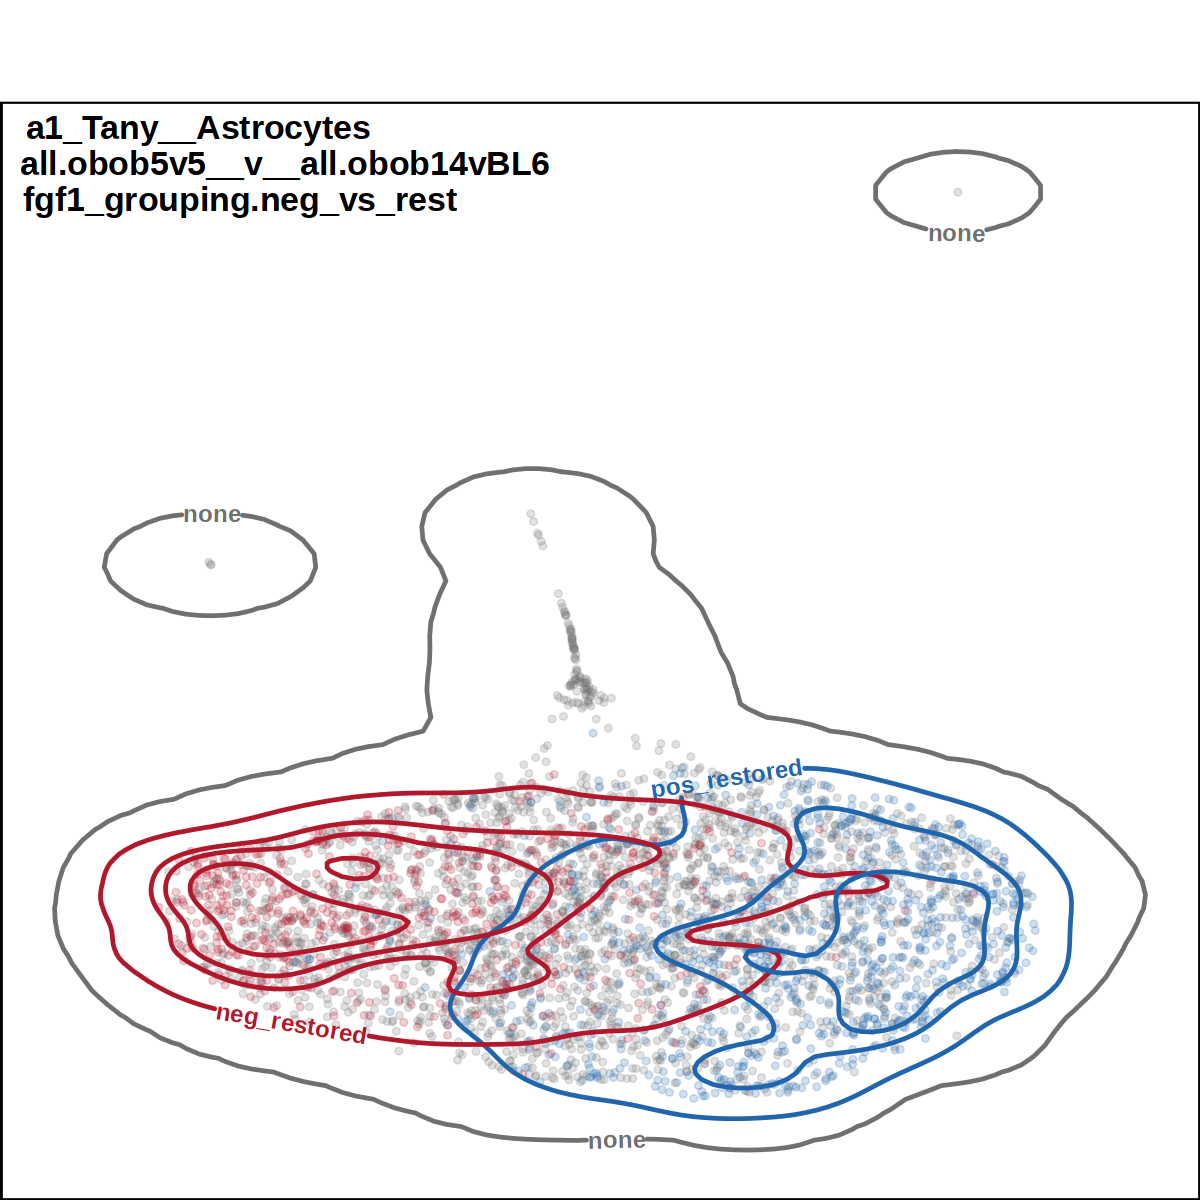

In [157]:
options(repr.plot.width=10, repr.plot.height=10)
gg = plot_group_overview(obj, nhgc, "restored_grouping", "a1_Tany__Astrocytes\nall.obob5v5__v__all.obob14vBL6\nfgf1_grouping.neg_vs_rest")

gg

In [61]:
plot_list = list(gg,
                 gg, gg, gg, gg, gg, gg, gg, gg,
                 gg, gg, gg, gg, gg, gg, gg, gg)

In [22]:
xl = ggplot_build(gg)$layout$panel_params[[1]]$x.range
yl = ggplot_build(gg)$layout$panel_params[[1]]$y.range

In [23]:
degs = qs::qread('_targets/objects/deg_ensmus_MOL___all.obob5v5__v__all.obobBL6___fgf1_grouping.pos_vs_neg')
degs %>% filter(p_val_adj < 0.001) %>% arrange(desc(avg_log2FC)) %>% dim
# degs %>% filter(p_val_adj < 0.001) %>% filter(abs(avg_log2FC) > 0.5) %>% head(20)
up_markers = degs %>% pull(GeneID) %>% head(8)
down_markers = degs %>% arrange(gsea_sort_score) %>% pull(GeneID) %>% head(8)

[1] 111   9

In [24]:
markers = c(up_markers, down_markers)

In [25]:
DefaultAssay(obj) = 'SCT'

In [26]:
make_fp_plot = function(obj, value){
    list(FeaturePlot(obj,
                slot='counts',
               cols = c("#eaeaea", "#323232"),
               features = c(value),
               pt.size=8,
               order=TRUE,
               min.cutoff="q01",
               max.cutoff="q99",
               raster=TRUE,
               raster.dpi=c(1024, 1024),
               ncol=1
               ) + 
                 xlim(xl[1], xl[2]) +
                 ylim(yl[1], yl[2]) +
                 theme_void() + 
#                  theme(plot.margin = unit(c(0.05, 0.05,0.05,0.05), "inches")) + 
                 theme(legend.position="none") + 
                 theme(plot.title = element_text(size=25,face = "bold",
                     margin = margin(b = -30, t=30), hjust = 0.03)) +
                 theme(panel.border = element_rect(colour = "black", fill=NA, size=1)))
}

In [50]:
make_plot_data = function(obj, nhgc_coords, gene){
    gene_vals = obj %>% `@`('assays') %>% `$`('SCT') %>% `@`('counts') %>% 
        `[`(gene,) %>% 
        enframe(name = 'rowname')
    max_cutoff_q = gene_vals %>% pull(value) %>% quantile(0.99)
    min_cutoff_q = gene_vals %>% pull(value) %>% quantile(0.01)
    plot_data = nhgc_coords %>% 
    left_join(gene_vals, by = 'rowname') %>%
    mutate(value = case_when(value > max_cutoff_q ~ max_cutoff_q,
                             value < min_cutoff_q ~ min_cutoff_q,
                             TRUE ~ value)) %>%
    arrange(value)
}

make_featureplot = function(obj, nhgc, grouping_col, gene){
    nhgc_coords = make_nhgc_coords(nhgc, obj, grouping_col)
    plot_data = make_plot_data(obj, nhgc_coords, gene)
    kde_df = make_kde_df(nhgc_coords)
    gg = ggplot() + 
        geom_point(data=plot_data, aes(x = UMAP_1, y = UMAP_2, colour=value)) +
        scale_colour_gradient(low = "#cce7d7", high = "#006f2d")
    gg = add_contours_no_label(gg, kde_df)
    gg = gg + labs(title=gene)
    gg = gg + 
         theme_void() + 
         theme(legend.position="none") + 
         theme(plot.title = element_text(size=25,face = "bold",
               margin = margin(b = -30, t=30), hjust = 0.03)) +
         theme(panel.border = element_rect(colour = "black", fill=NA, size=1))
    gg
}

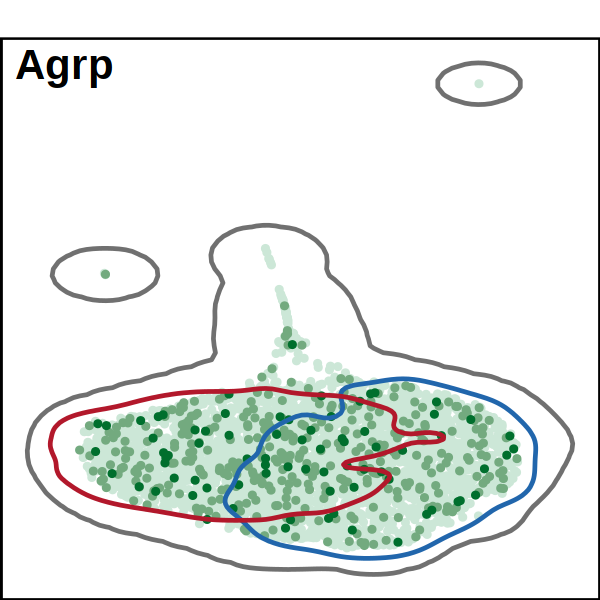

In [51]:
options(repr.plot.width=5, repr.plot.height=5)
make_featureplot(obj, nhgc, 'restored_grouping', 'Agrp')

In [79]:
plot_list = markers %>% 
enframe(value = 'GeneID') %>%
rowwise() %>%
mutate(fp = list(make_featureplot(obj, nhgc, 'restored_grouping', GeneID))) %>%
ungroup %>%
pull(fp)

plot_list = append(list(gg), plot_list)

In [81]:
options(repr.plot.width=13.33, repr.plot.height=15)

make_summary_layout = function(){
    layout <- c(
        area(103, 0, 647, 544),
        ###top 4.1
        area(26, 576, 207, 757),
        area(26, 757, 207, 938),
        area(26, 938, 207, 1119),
        area(26, 1119, 207, 1300),
        ## top 4.2
        area(207, 576, 388, 757),
        area(207, 757, 388, 938),
        area(207, 938, 388, 1119),
        area(207, 1119, 388, 1300),
        ### bottom 4.1
        area(420, 576, 601, 757),
        area(420, 757, 601, 938),
        area(420, 938, 601, 1119),
        area(420, 1119, 601, 1300),
        area(601, 576, 782, 757),
        area(601, 757, 782, 938),
        area(601, 938, 782, 1119),
        area(601, 1119, 782, 1300))
    layout
}

layout = make_summary_layout()
# Show the layout to make sure it looks as it should
# plot(layout)  + coord_fixed()

In [92]:
make_summary_deg_plot = function(obj, nhgc, degs, grouping_col, title){
    grouping_overview = plot_group_overview(obj, nhgc, grouping_col, title)
    up_markers = degs %>% pull(GeneID) %>% head(8)
    down_markers = degs %>% arrange(gsea_sort_score) %>% pull(GeneID) %>% head(8)
    markers = c(up_markers, down_markers)
    plot_list = markers %>% 
        enframe(value = 'GeneID') %>%
        rowwise() %>%
        mutate(fp = list(make_featureplot(obj, nhgc, grouping_col, GeneID))) %>%
        ungroup %>%
        pull(fp)
    plot_list = append(list(grouping_overview), plot_list)
    layout = make_summary_layout()
    gg_wrap = wrap_plots(plot_list, design = layout)
    gg_wrap
}

In [101]:
# options(repr.plot.width=11.7, repr.plot.height=8.3)
options(repr.plot.width=26.66, repr.plot.height=15)
gg_wrap = make_summary_deg_plot(obj, nhgc, degs, "fgf1_grouping", "test_restored_g_fgf1")

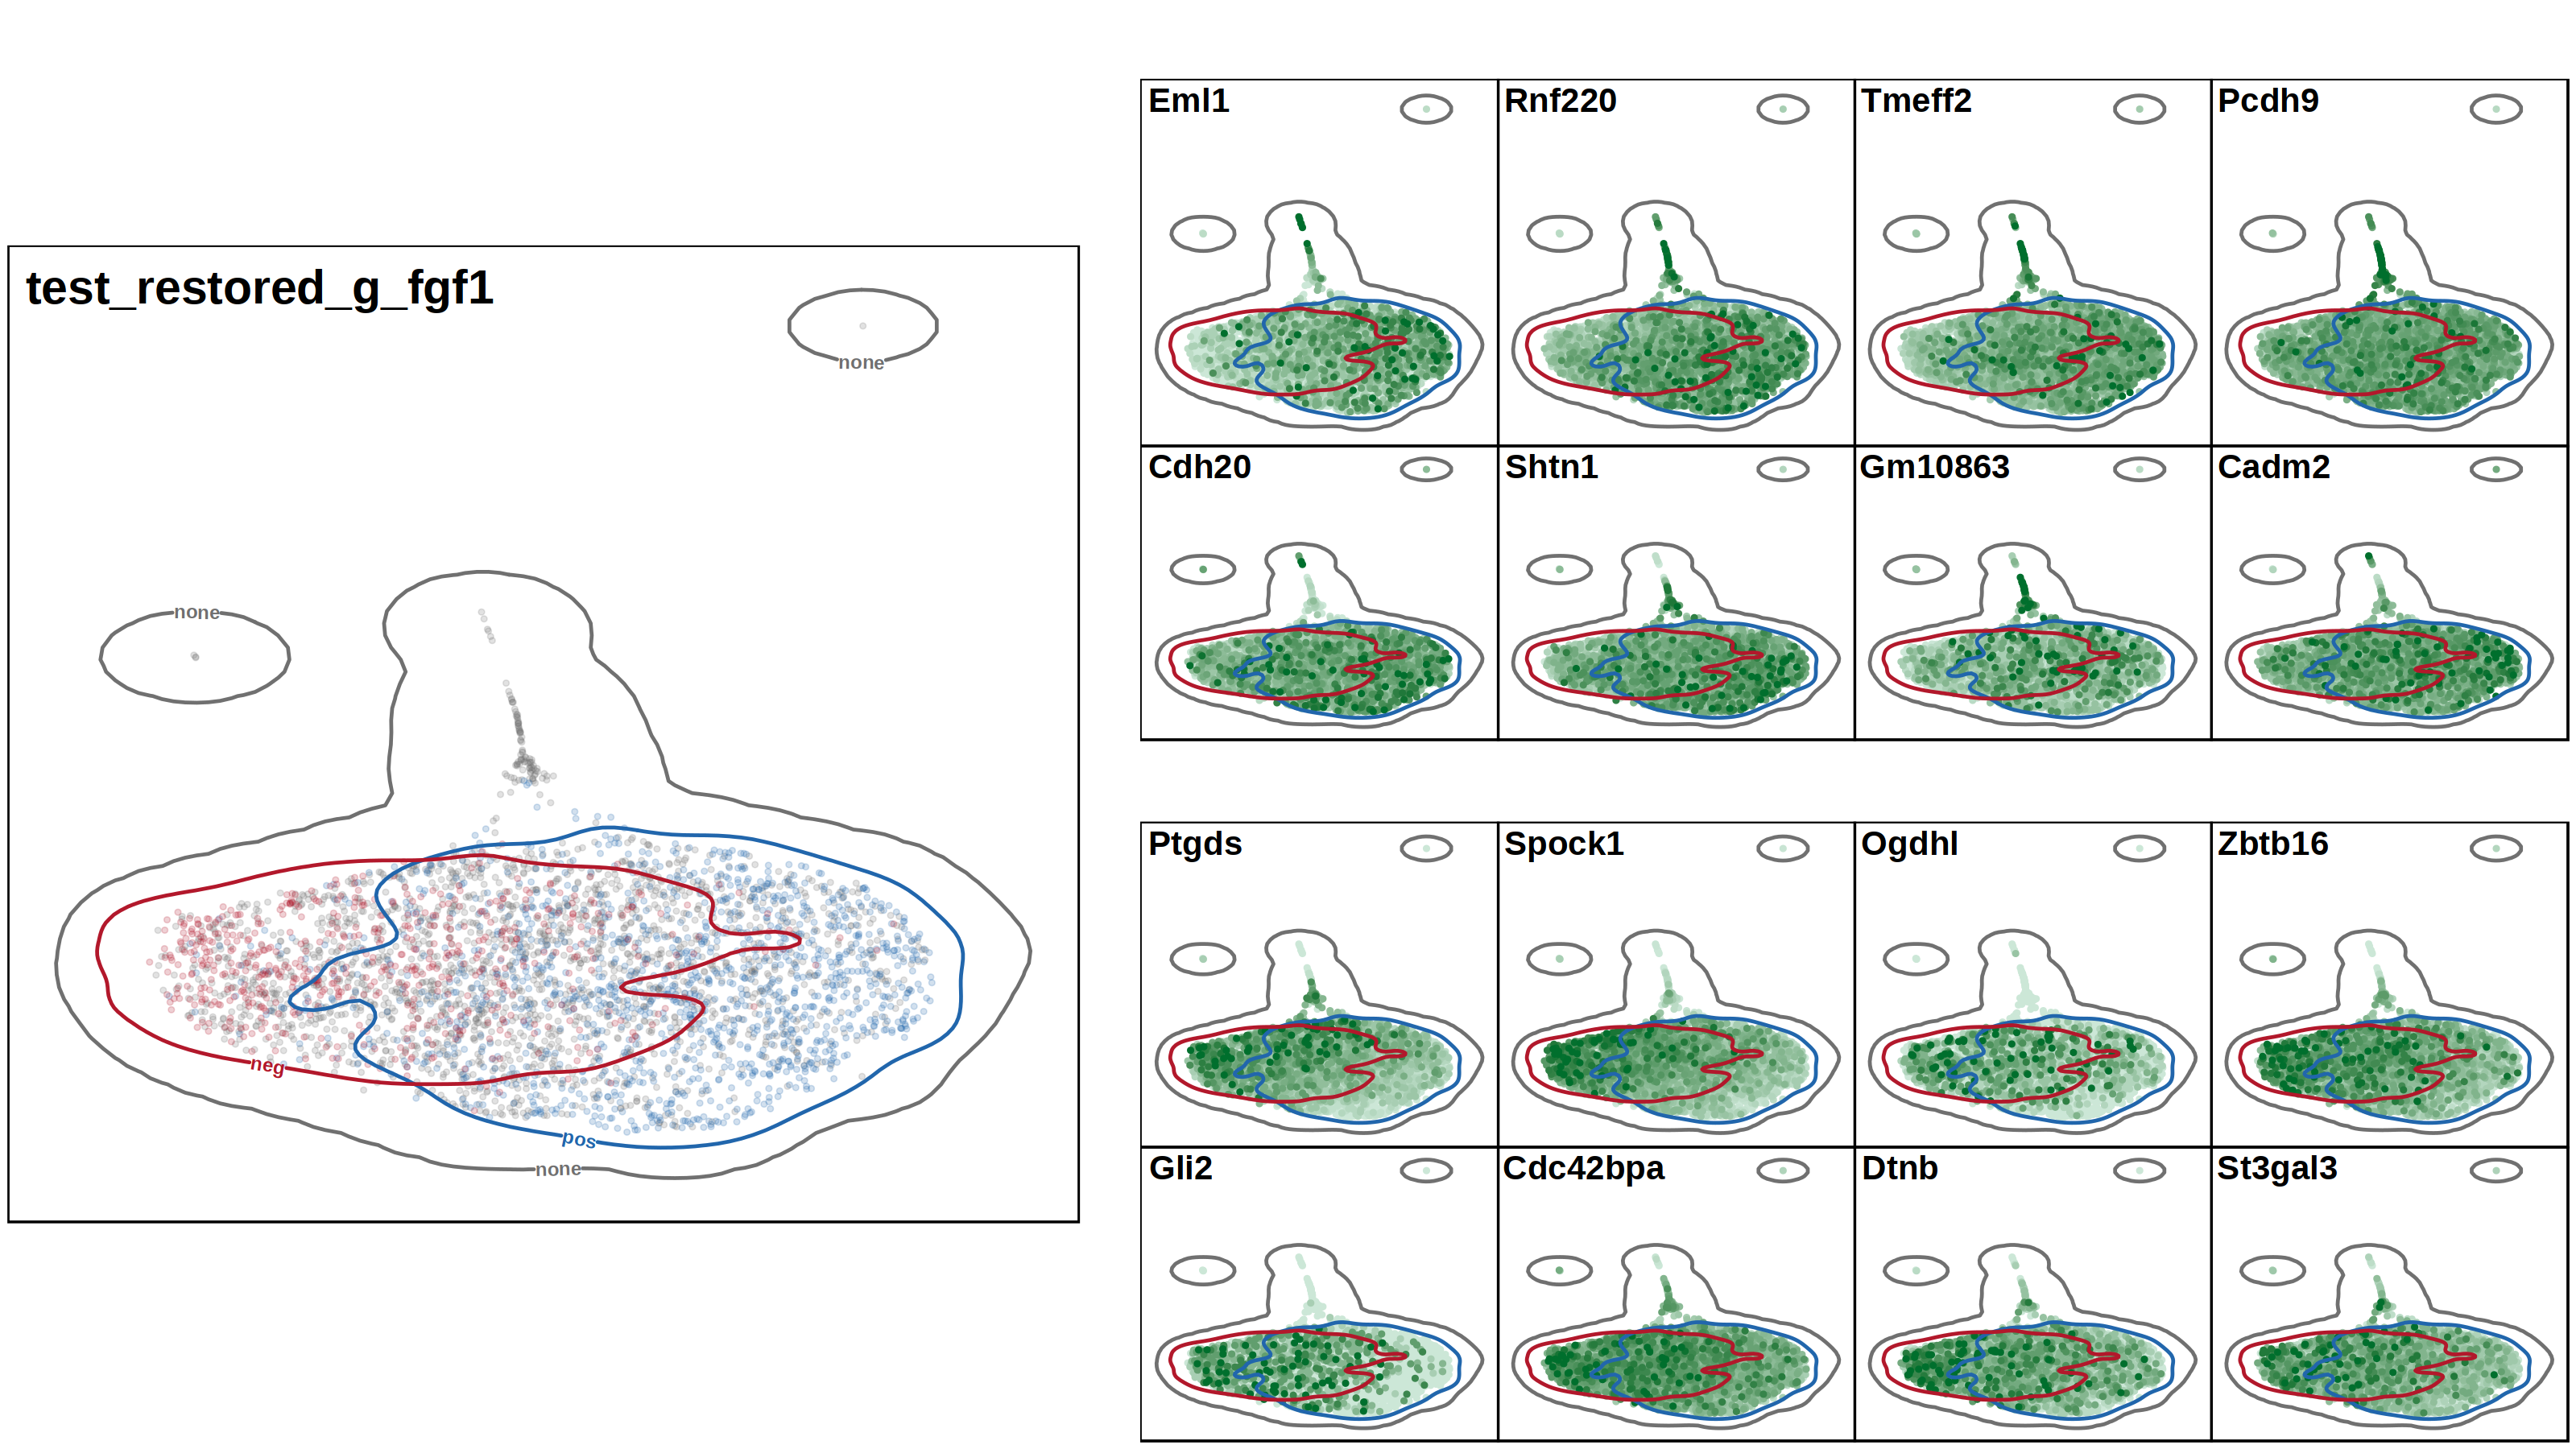

In [102]:
gg_wrap

In [103]:
2

[1] 2

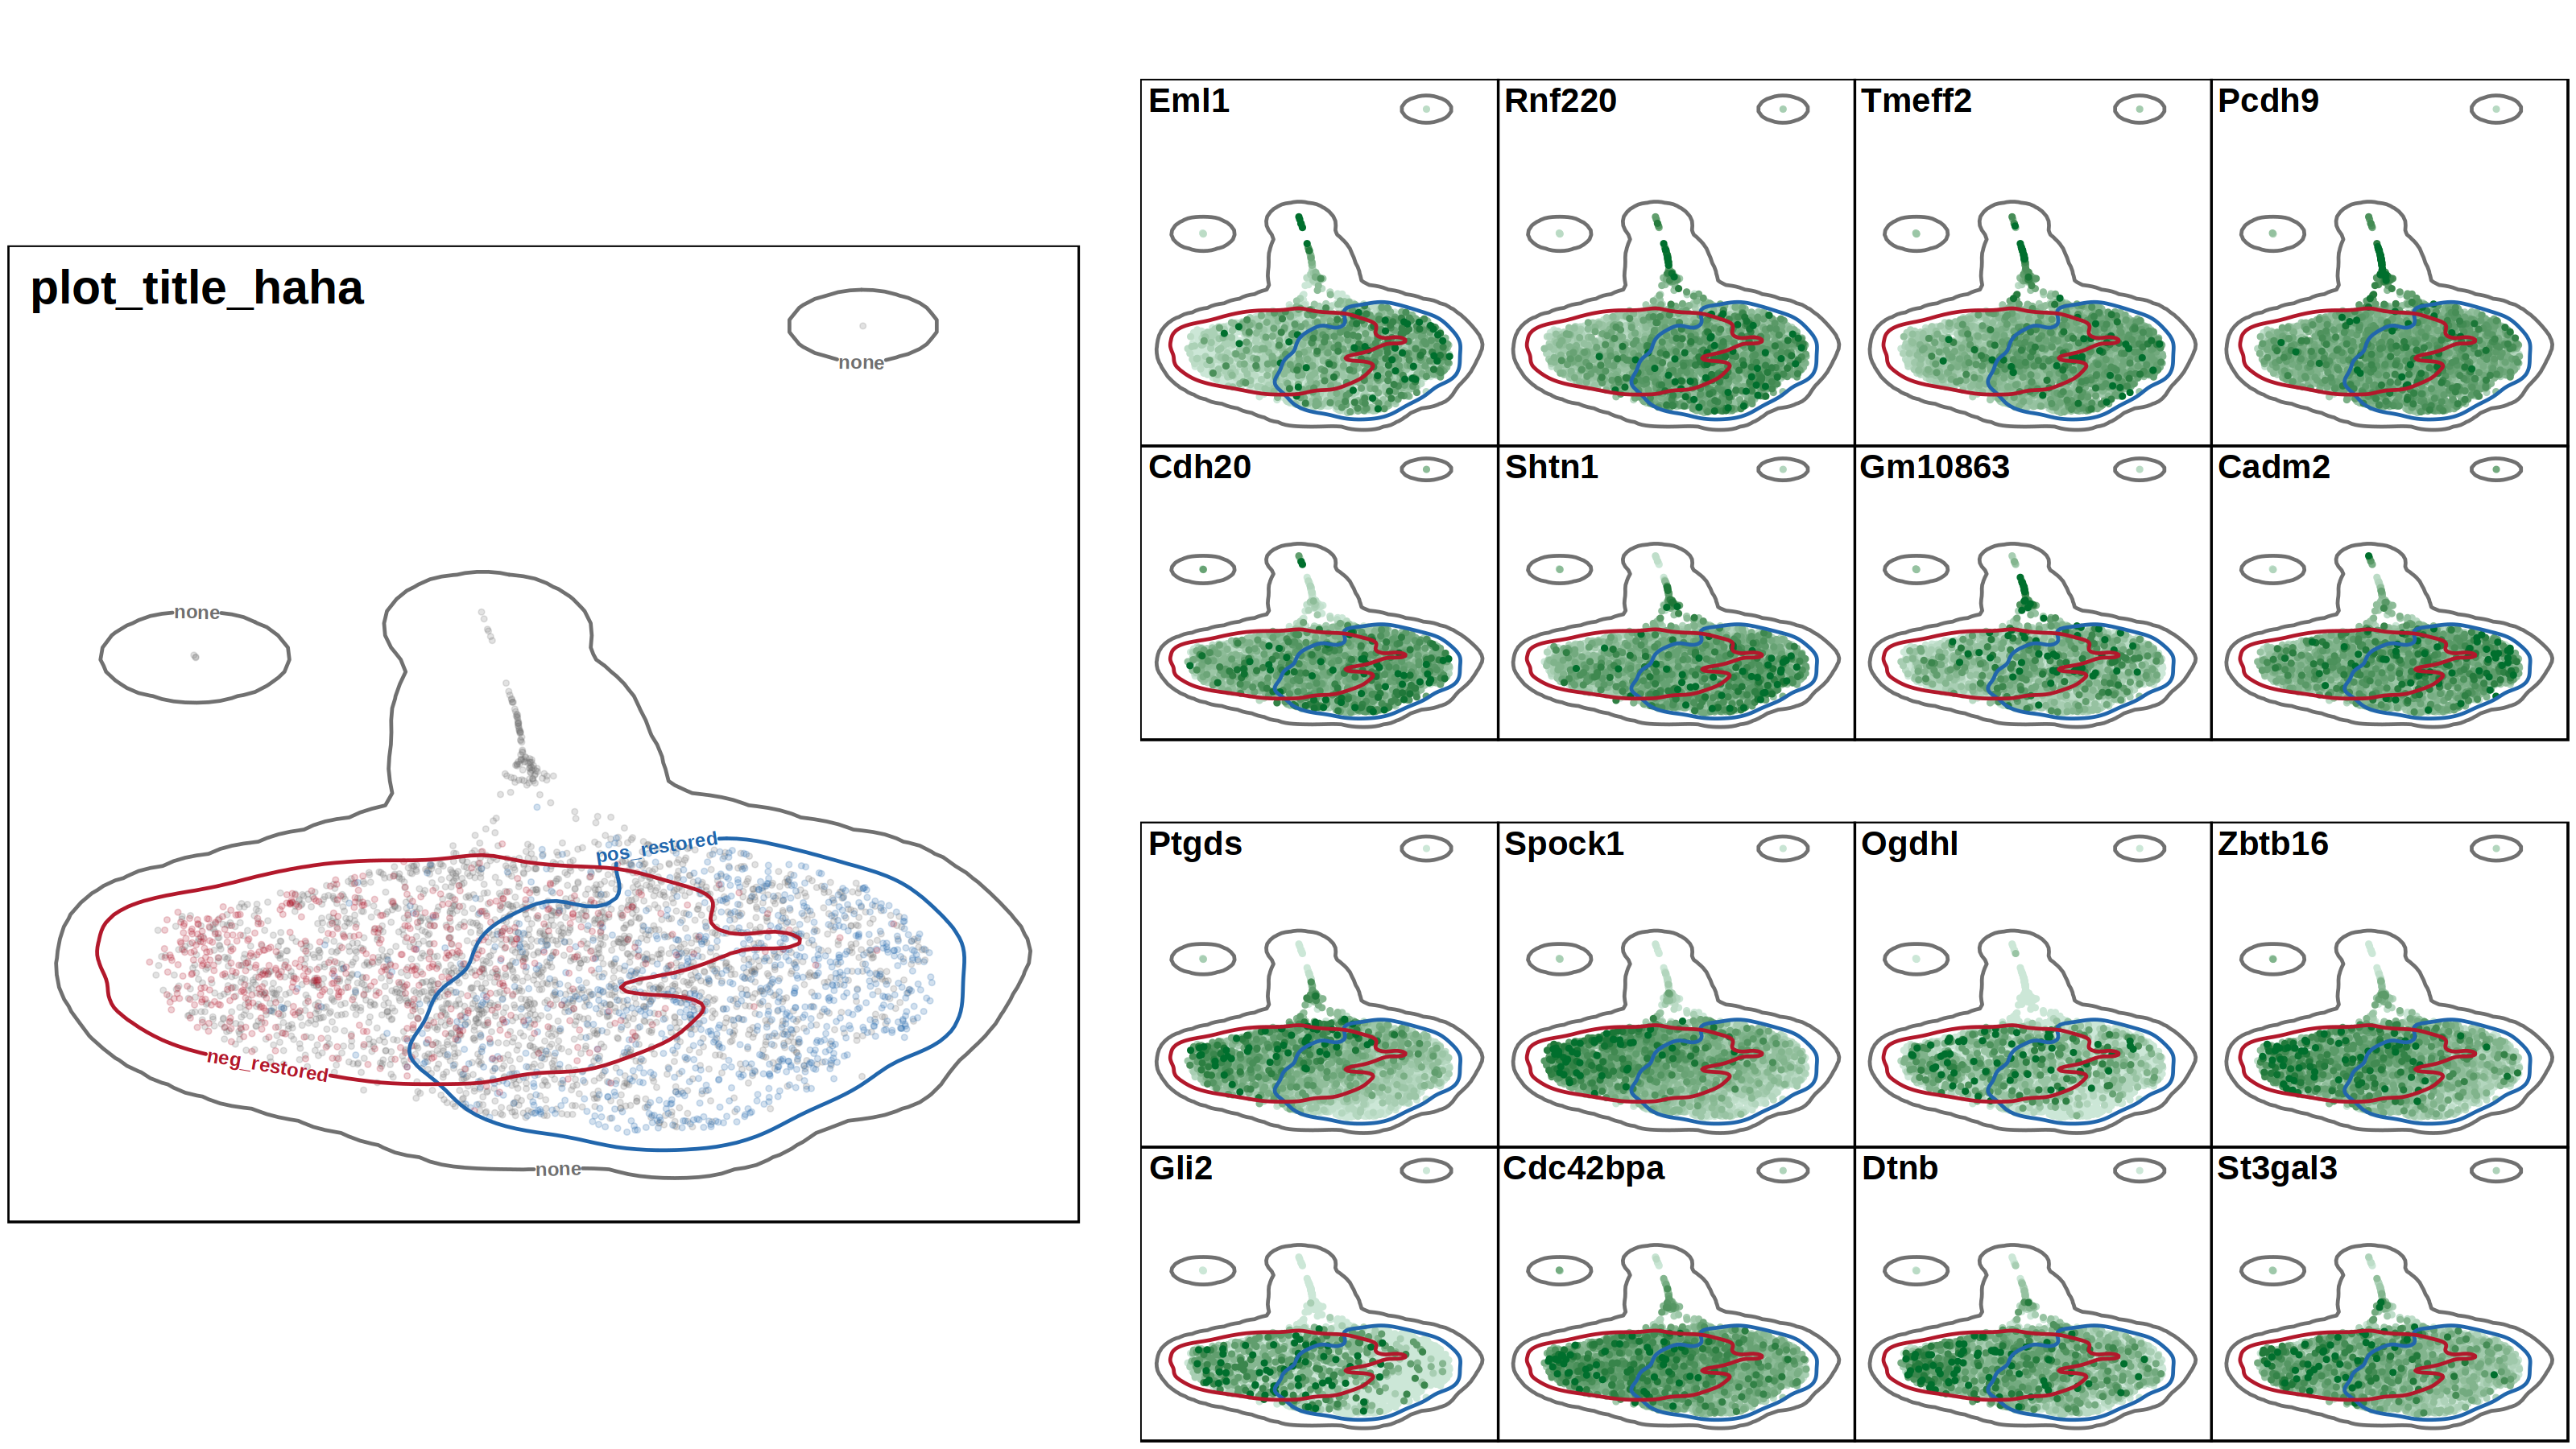

In [80]:
# options(repr.plot.width=11.7, repr.plot.height=8.3)
options(repr.plot.width=26.66, repr.plot.height=15)
gg_wrap = 
gg_wrap

In [58]:
ggsave('test.pdf',
       plot=gg_wrap,
       width=26.66,
       height=15,
       units=c("in"))

In [59]:
2

[1] 2

In [118]:
gg_wrap = qs::qread('_targets/objects/top_deg_summary_plot_gSCT_MOL___all.obob5v5__v__all.obobBL6___fgf1_grouping.pos_vs_neg')

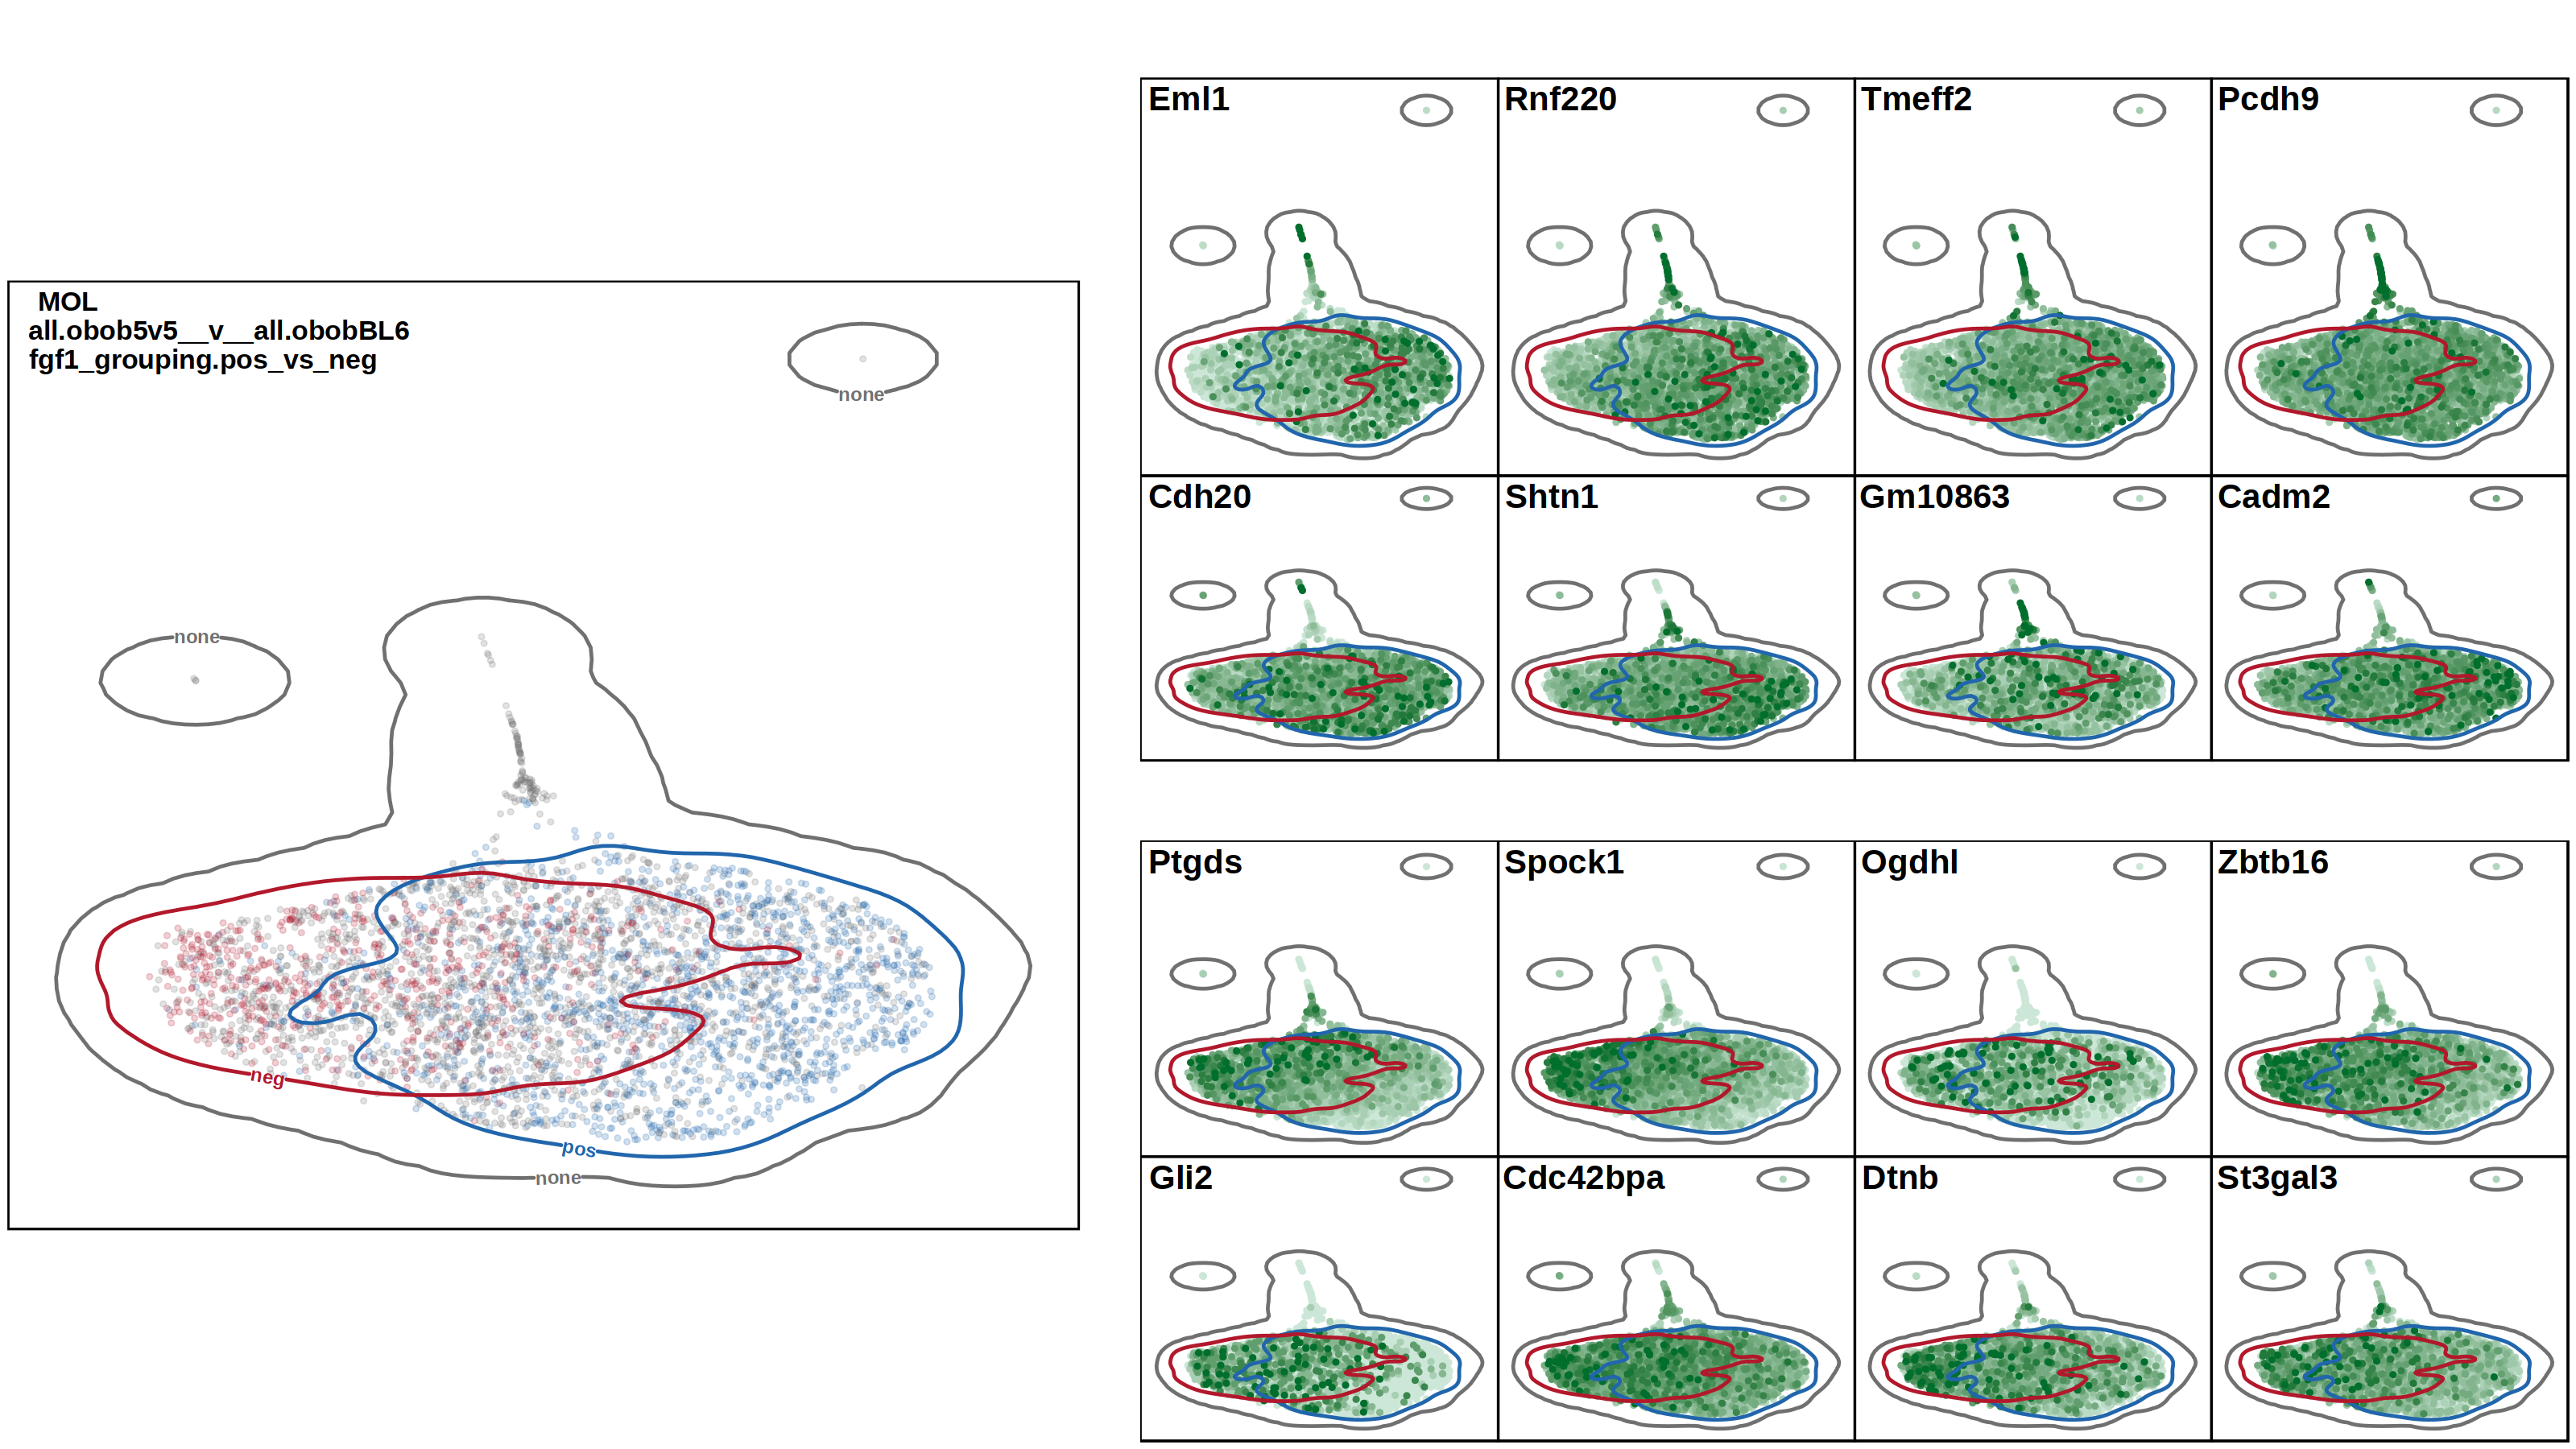

In [120]:
options(repr.plot.width=26.66, repr.plot.height=15)
gg_wrap

In [114]:
dir.create('/outputs/plots/deg_summary/', recursive = TRUE, showWarnings = FALSE)

In [116]:
name_components = c('blah', '123')
name_components = c('lol_', name_components)
name_components

[1] "lol_" "blah" "123"

In [135]:
save_summary_plot = function(summary_plot, name_components){
    dirpath = 'outputs/plots/deg_summary/'
    dir.create(dirpath, recursive = TRUE, showWarnings=FALSE)
    name_components = c(dirpath, name_components, '.pdf')
    plot_path = paste0(name_components, collapse = '')
    print(plot_path)
    ggsave(plot_path,
       plot=summary_plot,
       device='pdf',
       width=26.66,
       height=15,
       units=c("in"))  
}

In [136]:
save_summary_plot(gg_wrap, c("blah"))

[1] "outputs/plots/deg_summary/blah.pdf"


In [117]:
targets::tar_meta() %>% filter(str_detect(name, "top_deg")) %>% filter(!is.na(error))

name                                                                                                                          
1  top_deg_summary_plot_gSCT_MOL___all.obob5v5__v__all.obobBL6___fgf1_grouping.pos_vs_neg                                        
2  top_deg_summary_plot_reSCT_a1_Tany__Astrocytes___all.obob5v5__v__all.obobBL6d5___fgf1_grouping.pos_vs_none                    
3  top_deg_summary_plot_reSCT_Htr3b___all.obob5v5__v__all.obobBL6d14___restored_grouping.neg_restored_vs_none                    
4  top_deg_summary_plot_reSCT_NG2_OPC2___all.obob5v5__v__all.obobBL6d5___fgf1_grouping.pos_vs_neg                                
5  top_deg_summary_plot_reSCT_Pomc_Glipr1__Slc17a6_Trhr___all.obob5v5__v__all.obobBL6d14___fgf1_grouping.pos_vs_rest             
6  top_deg_summary_plot_reSCT_Pomc_Glipr1__Slc17a6_Trhr___all.obob5v5__v__all.obobBL6d14___restored_grouping.neg_restored_vs_none
7  top_deg_summary_plot_reSCT_Rgs16_Dlx1___all.obob5v5__v__all.obobBL6d14___fgf1_grouping.neg_vs_none                            
8  top_deg_summary_plot_reSCT_Tmem215___all.obob5v5__v__all.obobBL6d14___fgf1_grouping.pos_vs_rest                               
9  top_deg_summary_plot_reSCT_Tmem215___all.obob5v5__v__all.obobBL6d14___restored_grouping.pos_restored_vs_neg_restored          
10 top_deg_summary_plot_reSCT_Trh_Lef1___all.obob5v5__v__all.obobBL6d14___fgf1_grouping.pos_vs_neg                               
11 top_deg_summary_plot_reSCT_Trh_Lef1___all.obob5v5__v__all.obobBL6d5___fgf1_grouping.neg_vs_none                               
   type data  command          depend           seed        path
1  stem error a42ae0a8c3e77295 6af16663c525cbe4   359011079 NA  
2  stem error 9dcc6e34793bf8bd b805f5d87c2bfcb9  1154454839 NA  
3  stem error 1dc185a73aa54af1 67027631e142ba6a  -714144237 NA  
4  stem error 166061a3e396a43f 41a3dac9618931aa    62910816 NA  
5  stem error 8ee5dc57b8275651 c31907cc6d56cca2  -704368105 NA  
6  stem error 151deb812266fd43 c31907cc6d56cca2 -1624099746 NA  
7  stem error bbe8c8e7c2f2e874 9f911715c3f8f8d7   717152430 NA  
8  stem error 147421f6b1e9d092 42e0b56bb7ce37d9    74149234 NA  
9  stem error 92d5e5ade8e0c478 42e0b56bb7ce37d9   511032500 NA  
10 stem error 6bd39974329b30a7 fe3b7ec68a1629c3 -1803833139 NA  
11 stem error 3a50f5f2a40013da 4bf8d235d148a188   372037849 NA  
   time                size             bytes format repository iteration
1  2022-12-08 14:42:16 de1c6d017cb4e8a8 38    qs     local      vector   
2  2022-12-08 11:27:20 de1c6d017cb4e8a8 38    qs     local      vector   
3  2022-12-08 11:27:15 de1c6d017cb4e8a8 38    qs     local      vector   
4  2022-12-08 11:27:26 de1c6d017cb4e8a8 38    qs     local      vector   
5  2022-12-08 11:27:15 de1c6d017cb4e8a8 38    qs     local      vector   
6  2022-12-08 11:27:23 de1c6d017cb4e8a8 38    qs     local      vector   
7  2022-12-08 11:27:31 de1c6d017cb4e8a8 38    qs     local      vector   
8  2022-12-08 11:27:29 de1c6d017cb4e8a8 38    qs     local      vector   
9  2022-12-08 11:27:17 de1c6d017cb4e8a8 38    qs     local      vector   
10 2022-12-08 11:27:16 de1c6d017cb4e8a8 38    qs     local      vector   
11 2022-12-08 11:27:29 de1c6d017cb4e8a8 38    qs     local      vector   
   parent children seconds warnings
1  NA     NA        0.077  NA      
2  NA     NA       15.697  NA      
3  NA     NA       14.009  NA      
4  NA     NA        3.023  NA      
5  NA     NA       14.311  NA      
6  NA     NA       10.497  NA      
7  NA     NA       11.898  NA      
8  NA     NA       14.025  NA      
9  NA     NA       15.362  NA      
10 NA     NA       12.497  NA      
11 NA     NA       13.094  NA      
   error                                                                                                   
1  error in evaluating the argument x in selecting a method for function subset object exp_neuron not found
2  object deg_ensmus not found                                                                             
3  object deg_ensmu